In [67]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import re
import string
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB


In [68]:
nltk.download('words')
eng_words=set(nltk.corpus.words.words())
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
stopwords.extend(['book','story','read','reading','really','one'])

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
filepath='E:/Ramya/brushUps/Basics/ML using sklearn/Projects/Sentiment_analysis/data/goodreads_reviews_children.json'
with open(filepath) as f:
    lines=f.read().splitlines()

In [70]:
data_inter=pd.DataFrame(lines)
data_inter.columns=['json_element']

In [71]:
data_inter['json_element'].apply(json.loads)

0         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
1         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
2         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
3         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
4         {'user_id': '8842281e1d1347389f2ab93d60773d4d'...
                                ...                        
734635    {'user_id': '480ac8b4df39533a6c7fe6ae109aa56a'...
734636    {'user_id': 'afcd096765a8c354be0706ab1324999b'...
734637    {'user_id': 'd94c83867337514c94738b57a1d19677'...
734638    {'user_id': '48a10d546ba07520ce194dc18e687be4'...
734639    {'user_id': 'da6f9516279ed671027308abd21318bd'...
Name: json_element, Length: 734640, dtype: object

In [72]:
data=pd.json_normalize(data_inter['json_element'].apply(json.loads))

In [73]:
reviews_data=data[['book_id','rating','review_text']]

In [74]:
def reviewsTextCleaning(review):
    review=review.lower()
    review=review.strip()
    review=review.replace('\n','')
    review=review.replace('\t','')
    review=review.translate(str.maketrans('','',string.punctuation))
    review=re.sub(r'\d+','',review)
    review=re.sub(r'^https?:\/\/.*[\r\n]*','',review)
    remove_tags=re.compile('<.*?>')
    review=re.sub(remove_tags,'',review) 
    review=' '.join(w for w in nltk.wordpunct_tokenize(review) if w.lower() in eng_words or not w.isalpha())
    return review                                                                                                                                                                                                                                                                                                                                                   

In [75]:
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

In [76]:
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

In [77]:
def polarityInference(score):
    if score >0:
        return 1
    elif score ==0:
        return 0
    else:
        return -1


In [78]:
reviews_data['subjectivity_Score']=reviews_data['review_text'].apply(getSubjectivity)
reviews_data['polarity_Score']=reviews_data['review_text'].apply(getPolarity)
reviews_data['sentiment']=reviews_data['polarity_Score'].apply(polarityInference)

<ipython-input-78-966daec32401>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['subjectivity_Score']=reviews_data['review_text'].apply(getSubjectivity)
<ipython-input-78-966daec32401>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_data['polarity_Score']=reviews_data['review_text'].apply(getPolarity)
<ipython-input-78-966daec32401>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [79]:
reviews_data.columns

Index(['book_id', 'rating', 'review_text', 'subjectivity_Score',
       'polarity_Score', 'sentiment'],
      dtype='object')

In [80]:
classi_data=reviews_data[['review_text','sentiment']]

In [81]:
tfidf=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,max_df=0.8,min_df=0.2)
tfidf_matrix=tfidf.fit_transform(classi_data['review_text'])
tfidf_matrix.shape

(734640, 3)

In [82]:
tfidf_matrix

<734640x3 sparse matrix of type '<class 'numpy.float64'>'
	with 789558 stored elements in Compressed Sparse Row format>

In [100]:
X_train,X_test,y_train,y_test=train_test_split(tfidf_matrix,np.array(classi_data['sentiment']).reshape(-1,1),test_size=0.2,random_state=42)

In [84]:
clf=MultinomialNB()

In [85]:
clf.fit(X_train,y_train)

C:\Users\ramya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()

In [86]:
y_pred=clf.predict(X_test)

In [87]:
score=f1_score(y_test,y_pred,average='weighted')
cm=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=['-1','0','1'],index=['-1','0','1'])

In [88]:
score

0.7508227989892009

In [89]:
v=classi_data['sentiment'].value_counts()

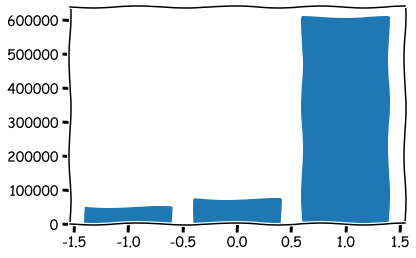

In [90]:
from matplotlib import pyplot as plt
with plt.xkcd():
    plt.bar(v.index,v.values)
    plt.show()

In [91]:
cm

,-1,0,1
-1,0,0,10128
0,0,0,15067
1,0,0,121733
